In [1]:
import pandas as pd
from itertools import islice
from string import digits
import matplotlib.pyplot as plt
import numpy as np
import os

os.getcwd()

'/home/nishon/Projects/jupyter-notebook/retina-net-training'

# 1. Load csv generated from annotation tool

**Exported data format from DarkLabel**
```
frame,total label apperence, [ x, y, w, h, label ]`
```

**The format we prefer**
```
frame,x1,y1,x2,y2,label`
```


In [2]:
video_name = "DJI_0005"
path_to_data = '{0}_gt.txt'.format(video_name)
formatted_image_name = "imgs/{0}_{1}.jpg";

print(path_to_data)
print(formatted_image_name)

DJI_0005_gt.txt
imgs/{0}_{1}.jpg


In [3]:
remove_digits = str.maketrans('', '', digits)
## breaks a long list into list of provided chucks(size)
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

In [4]:
#https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/boxes.py
def xywh_to_xyxy(xywh):
    """Convert [x1 y1 w h] box format to [x1 y1 x2 y2] format."""
    if isinstance(xywh, (list, tuple)):
        # Single box given as a list of coordinates
        assert len(xywh) == 4
        x1, y1 = xywh[0], xywh[1]
        x2 = x1 + np.maximum(0., xywh[2] - 1.)
        y2 = y1 + np.maximum(0., xywh[3] - 1.)
        return (x1, y1, x2, y2)
    elif isinstance(xywh, np.ndarray):
        # Multiple boxes given as a 2D ndarray
        return np.hstack(
            (xywh[:, 0:2], xywh[:, 0:2] + np.maximum(0, xywh[:, 2:4] - 1))
        )
    else:
        raise TypeError('Argument xywh must be a list, tuple, or numpy array.')



AxesSubplot(0.125,0.125;0.775x0.755)


Index(['file_path', 'label', 'x1', 'x2', 'y1', 'y2'], dtype='object')

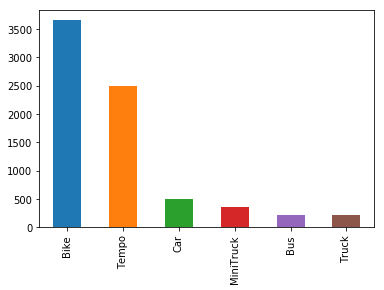

In [5]:
df = []
with open(path_to_data, 'r') as f:
    for line in f:
        a_list = line.split(',')
        chunked = list(chunk(a_list[2:], 5))
        for item in chunked:
            (x1,y1,x2,y2) = xywh_to_xyxy([int(item[0]),int(item[1]),int(item[2]),int(item[3])])
        
            df.append({
                'file_path':formatted_image_name.format(video_name,a_list[0]),
                'x1':int(x1),
                'y1':int(y1),
                'x2':int(x2),
                'y2':int(y2),
                'label': item[4].strip().translate(remove_digits)
                      })
            
            
df = pd.DataFrame(df) 


#plot
print(pd.value_counts(df['label']).plot.bar())
len(df.groupby('file_path'))
df.columns


In [6]:
classes = df.groupby('label')
classes.all()

,file_path,x1,x2,y1,y2
label,,,,,
Bike,True,True,True,False,True
Bus,True,True,True,True,True
Car,True,False,True,False,True
MiniTruck,True,True,True,False,True
Tempo,True,True,True,False,True
Truck,True,True,True,False,True


In [7]:
df.dtypes

file_path    object
label        object
x1            int64
x2            int64
y1            int64
y2            int64
dtype: object

# 2. Check if any duplicate data

In [8]:
duplicate_rows = df[df.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicate_rows)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [file_path, label, x1, x2, y1, y2]
Index: []


# 3. Validate frame and image mapping

In [9]:
import cv2

In [10]:
def get_frame_no(file_name):
    return file_name.split("-")[1].split(".")[0]

### 3.1 Get random photo

In [11]:
seed_row = df.sample(n=1,replace=True)
image_path = seed_row['file_path'].values[0]
random_row = df[df.file_path == image_path]
print(image_path)
os.path.exists(image_path)

imgs/DJI_0005_242.jpg


False

### 3.2 Get random photo (Alternative approach)

In [12]:
from random import randrange
random_index = randrange(len(df))
image_path = df.iloc[random_index]['file_path']

print(random_index)
print(df.iloc[random_index])
print(image_path)

5319
file_path    imgs/DJI_0005_5444.jpg
label                         Tempo
x1                              652
x2                              698
y1                              518
y2                              567
Name: 5319, dtype: object
imgs/DJI_0005_5444.jpg


## Get all classes from that photo

In [13]:
df_to_plot = df[df.file_path==image_path]
df_to_plot.groupby('label')
print(len(df_to_plot))

99


In [14]:
cv2.namedWindow('image', cv2.WINDOW_FULLSCREEN)
img = cv2.imread("data/"+image_path, 1)

for row in df_to_plot.itertuples():
    cv2.rectangle(img, (int(row.x1), int(row.y1)), (int(row.x2), int(row.y2)), (255, 0, 0), 2)

cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 4 Train test split

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.4,random_state=1)
test,val = train_test_split(df,test_size=0.2)

print(len(train))
print(len(test))
print(len(val))


4456
5942
1486


AxesSubplot(0.125,0.125;0.775x0.755)
Index(['file_path', 'label', 'x1', 'x2', 'y1', 'y2'], dtype='object')


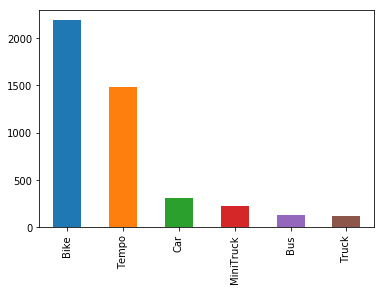

In [16]:
print(pd.value_counts(train['label']).plot.bar())
print(train.columns)

AxesSubplot(0.125,0.125;0.775x0.755)


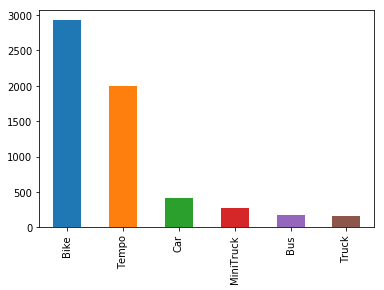

In [17]:
print(pd.value_counts(test['label']).plot.bar())

AxesSubplot(0.125,0.125;0.775x0.755)


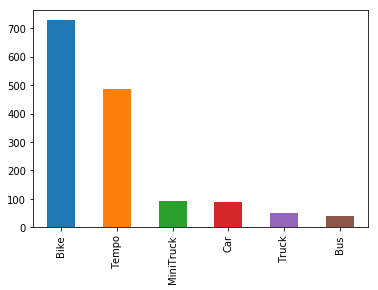

In [18]:
print(pd.value_counts(val['label']).plot.bar())

In [19]:
def rearrange(df):
    return df.reindex(columns=['file_path', 'x1', 'y1', 'x2', 'y2', 'label'])

In [20]:
rearrange(train).to_csv("data/train.csv",header=False,index=False)
rearrange(train).to_csv("data/test.csv",header=False,index=False)
rearrange(train).to_csv("data/val.csv",header=False,index=False)

In [21]:
import pandas as pd
pd.read_csv('data/train.csv').head()

,imgs/DJI_0005_247.jpg,1191,865,1226,900,Bike
0,imgs/DJI_0005_5430.jpg,455,53,497,103,Tempo
1,imgs/DJI_0005_1182.jpg,444,90,479,118,Bike
2,imgs/DJI_0005_5435.jpg,1036,600,1092,671,Car
3,imgs/DJI_0005_1184.jpg,831,615,871,652,Bike
4,imgs/DJI_0005_5429.jpg,1012,459,1045,492,Bike


In [1]:
file = open("data/train.csv")
numline = len(file.readlines())
print (numline)

4456


In [2]:
!aerial_pedestrian_detection/keras_retinanet/bin/train.py -h

Using TensorFlow backend.
usage: train.py [-h]
                [--snapshot SNAPSHOT | --imagenet-weights | --weights WEIGHTS | --no-weights]
                [--backbone BACKBONE] [--batch-size BATCH_SIZE] [--gpu GPU]
                [--multi-gpu MULTI_GPU] [--multi-gpu-force] [--epochs EPOCHS]
                [--steps STEPS] [--lr LR] [--snapshot-path SNAPSHOT_PATH]
                [--tensorboard-dir TENSORBOARD_DIR] [--no-snapshots]
                [--no-evaluation] [--freeze-backbone] [--random-transform]
                [--image-min-side IMAGE_MIN_SIDE]
                [--image-max-side IMAGE_MAX_SIDE] [--config CONFIG]
                [--weighted-average] [--workers WORKERS]
                [--max-queue-size MAX_QUEUE_SIZE]
                {coco,pascal,kitti,oid,csv} ...

Simple training script for training a RetinaNet network.

positional arguments:
  {coco,pascal,kitti,oid,csv}
                        Arguments for specific dataset types.

optional arguments:
  -h, --help        

In [7]:
!aerial_pedestrian_detection/keras_retinanet/bin/train.py --weights 'resnet50_coco_best_v2.1.0.h5'  csv 'data/train.csv' 'data/labels.csv' --val-annotations 'data/val.csv' 

Using TensorFlow backend.
aerial_pedestrian_detection/keras_retinanet/bin/train.py:353: UserWarning: Using experimental backbone mobilenet224_1.0. Only resnet50 has been properly tested.
  warnings.warn('Using experimental backbone {}. Only resnet50 has been properly tested.'.format(parsed_args.backbone))
W0808 17:17:03.351084 140605350999872 deprecation_wrapper.py:119] From aerial_pedestrian_detection/keras_retinanet/bin/train.py:66: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0808 17:17:03.351236 140605350999872 deprecation_wrapper.py:119] From aerial_pedestrian_detection/keras_retinanet/bin/train.py:68: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2019-08-08 17:17:03.357905: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-08-08 17:17:03.380255: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Fre

conv_pw_9 (Conv2D)              (None, None, None, 5 262144      conv_dw_9_relu[0][0]             
__________________________________________________________________________________________________
conv_pw_9_bn (BatchNormalizatio (None, None, None, 5 2048        conv_pw_9[0][0]                  
__________________________________________________________________________________________________
conv_pw_9_relu (ReLU)           (None, None, None, 5 0           conv_pw_9_bn[0][0]               
__________________________________________________________________________________________________
conv_dw_10 (DepthwiseConv2D)    (None, None, None, 5 4608        conv_pw_9_relu[0][0]             
__________________________________________________________________________________________________
conv_dw_10_bn (BatchNormalizati (None, None, None, 5 2048        conv_dw_10[0][0]                 
__________________________________________________________________________________________________
conv_dw_10

W0808 17:17:12.315682 140605350999872 deprecation_wrapper.py:119] From /home/nishon/anaconda3/envs/tf_gpu-2/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0808 17:17:12.315881 140605350999872 deprecation_wrapper.py:119] From /home/nishon/anaconda3/envs/tf_gpu-2/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

Epoch 1/50
2019-08-08 17:17:17.753079: W tensorflow/core/framework/op_kernel.cc:1502] OP_REQUIRES failed at gather_nd_op.cc:47 : Invalid argument: indices[185999] = [0, 188734] does not index into param shape [1,184653,6]
Traceback (most recent call last):
  File "aerial_pedestrian_detection/keras_retinanet/bin/train.py", line 509, in <module>
    main()
  File "aerial_pedestrian_detection/keras_retinanet/bin/train.py", line 504, in main
    max_queue_size=args.max_queue_size
  F

# Data conversion for TensorFlow